# Michelin Rated Restaurants in France - Processing

In [1]:
# Module import (comprehensive for entire notebook)
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import mapclassify
import folium
import branca

----
&nbsp;
## Import the French dataset

In [2]:
france = pd.read_csv("../../data/France/france_master.csv")
france.head()

,name,address,city,country,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,France,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,France,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,"5 avenue Saint-Victor, Fontjoncouse, 11360, Fr...",Fontjoncouse,France,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,"Larsiallas, Saint-Bonnet-le-Froid, 43290, France",Saint-Bonnet-le-Froid,France,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


In [3]:
# We change 'city' to 'location'
france.rename(columns={'city': 'location'}, inplace=True)

In [4]:
print(f"Shape of DataFrame: {france.shape}")
print(f"Unique Locations: {len(france['location'].unique())}")
print(f"Columns:\n{france.columns.unique().tolist()}")

Shape of DataFrame: (1033, 11)
Unique Locations: 617
Columns:
['name', 'address', 'location', 'country', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']


----
&nbsp;
## Restaurant Locations Visualisation

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

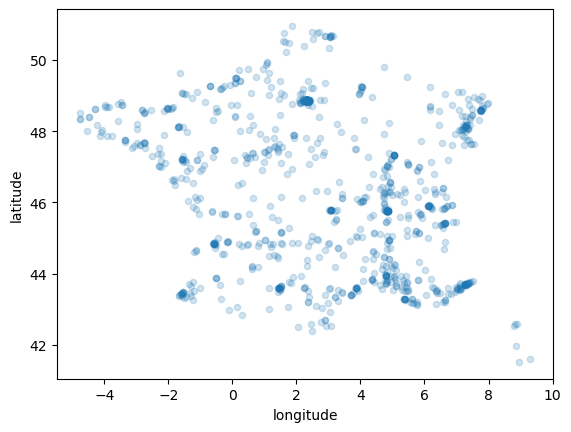

In [5]:
france.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2)

The datapoints trace the map of France quite well!

There are clusters in the Côte d'Azur, following the Rhone, the German border and in Paris

In [6]:
# Filter the data
filtered_france_data = france[france['stars'] != 0.5]

# Create a color map
colormap = branca.colormap.StepColormap(colors=['lightblue','yellow', 'red'],
                                          index=[0,1,2,3], # Define the index for the colors
                                          vmin=0,
                                          vmax=3)

# Create a map centered on France
france_map = folium.Map(location=[46.603354, 1.888334], tiles='Stamen Terrain', zoom_start=6)

# Add a legend
colormap.caption = 'Michelin Stars'
france_map.add_child(colormap)

# Add a marker for each point in your data
for idx, row in filtered_france_data.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['stars']),  # Use the 'stars' value to determine the color
        fill=True,
        fill_opacity=0.1  # Control the opacity here
    ).add_to(france_map)

# Add the color map legend to the map
colormap.add_to(france_map)

# Display the map (This is commented out)
#france_map

Static image of the above plot.

Running in own Jupyter environment allows interactivity

![img](../../Images/Static_france.png)

----
&nbsp;
## Partitioning the data regionally.

#### Creating new columns `department` & `region`

We import the `departments.csv` data which was created in `Data_preparation.ipynb`

In [7]:
departments = pd.read_csv("../../data/France/Demographics/departments.csv")
departments.head()

,department_num,department,capital,region
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes
1,02,Aisne,Laon,Hauts-de-France
2,03,Allier,Moulins,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur


We create a copy of `france_data` and extract the first two digits of code postal in `address`

In [8]:
france_data = france.copy()
france_data['department_num'] = france_data['address'].str.extract(r'(\b\d{5}\b)', expand=False).str[:2]

In [9]:
france_data = france_data.merge(departments, on='department_num', how='left')
print(france_data.columns.tolist())

['name', 'address', 'location', 'country', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude', 'department_num', 'department', 'capital', 'region']


In [10]:
france_data = france_data[['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'country',
                           'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']]
france_data.head()

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,83,Var,Toulon,Provence-Alpes-Côte d'Azur,France,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,73,Savoie,Chambéry,Auvergne-Rhône-Alpes,France,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,75,Paris,Paris,Île-de-France,France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,"5 avenue Saint-Victor, Fontjoncouse, 11360, Fr...",Fontjoncouse,11,Aude,Carcassonne,Occitanie,France,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,"Larsiallas, Saint-Bonnet-le-Froid, 43290, France",Saint-Bonnet-le-Froid,43,Haute-Loire,Le Puy-en-Velay,Auvergne-Rhône-Alpes,France,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


----
&nbsp;
### Amendments to the address and location formatting

In [11]:
# Check for addresses without a comma or with more than 3 commas (indicating more than 4 fields)
incorrect_format = france_data[~france_data['address'].str.count(',').isin([1, 2, 3])]

In [12]:
# Print out number addresses that don't match the expected format
if not incorrect_format.empty:
    print(f"Addresses with unexpected format: {len(incorrect_format['address'])}")

Addresses with unexpected format: 74


There exist a few addresses with multiple lines proceeding a standard form, "location", "postal code", "France"

In [13]:
def process_address(addr):
    # Split the address by commas and strip whitespace
    parts = [part.strip() for part in addr.split(',')]

    # If there are not enough parts, just return the original
    if len(parts) < 4:
        return addr, None, None

    # Extract the postal code and city
    postal_code = parts[-2]
    location = parts[-3]

    # Form the main address by joining the remaining parts (excluding postal code, city, and country)
    main_address = ', '.join(parts[:-3])

    return main_address, location, postal_code

In [14]:
# Apply the function to the DataFrame
addresses, locations, postal_codes = zip(*france_data['address'].apply(process_address))

france_data['address'] = addresses
france_data['location'] = [f"{location}, {postal_code}" for location, postal_code in zip(locations, postal_codes)]

In [15]:
france_data.head()

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,Plage de la Bouillabaisse,"Saint-Tropez, 83990",83,Var,Toulon,Provence-Alpes-Côte d'Azur,France,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,Hameau de Saint-Marcel,"Saint-Martin-de-Belleville, 73440",73,Savoie,Chambéry,Auvergne-Rhône-Alpes,France,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,5 rue du Coq-Héron,"Paris, 75001",75,Paris,Paris,Île-de-France,France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,5 avenue Saint-Victor,"Fontjoncouse, 11360",11,Aude,Carcassonne,Occitanie,France,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,Larsiallas,"Saint-Bonnet-le-Froid, 43290",43,Haute-Loire,Le Puy-en-Velay,Auvergne-Rhône-Alpes,France,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


In [16]:
# Check for the presence of commas in the 'address' column
contains_commas = france_data[france_data['address'].str.contains(',')]
print(f'Two-part addresses: {len(contains_commas)}')

Two-part addresses: 76


We've acquired 2 more restaurants with commas in the address

In [17]:
comma_addresses = france_data[france_data['address'].str.contains(',')]
address_parts = comma_addresses['address'].str.split(',').apply(len)
print(address_parts.value_counts())

2    69
3     7
Name: address, dtype: int64


In [18]:
three_part_addresses = comma_addresses[comma_addresses['address'].str.split(',').apply(len) == 3]
three_part_addresses[['address']]

,address
39,"Le K2 Altitude, 356 route de l'Altiport, Courc..."
81,"Le K2 Palace, 238 rue des Clarines, Courchevel..."
200,"Le Strato, Route de Bellecôte, Courchevel 1850"
385,"Lacave, 46200, France"
387,"Lacave, 46200, France"
520,"Alpaga, 66 allée des Marmoussets, route du Pra..."
587,"Maison Bouvier, rue du Val-Claret, au Val-Claret"


In [19]:
# Access rows by index
rows_to_amend = france_data.loc[[385, 387]]
rows_to_amend

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,longitude,latitude
385,Le Pont de l'Ouysse,"Lacave, 46200, France","None, None",46,Lot,Cahors,Occitanie,France,€€€,"Modern Cuisine, Classic Cuisine",https://www.lepontdelouysse.com/,1 MICHELIN Star,1.0,1.550233,44.844231
387,Château de la Treyne,"Lacave, 46200, France","None, None",46,Lot,Cahors,Occitanie,France,€€€€,Classic Cuisine,https://www.chateaudelatreyne.com/fr/restauran...,1 MICHELIN Star,1.0,1.525388,44.849474


We search for an address manually using the url. *Lacave* is a small village in the Dordogne. The address is simply the Hotel name, commune, postal code

In [20]:
france_data.at[385, 'address'] = 'Lacave, 46200'
france_data.at[387, 'address'] = 'Lacave, 46200'

france_data.at[385, 'location'] = 'Lacave, 46200'
france_data.at[387, 'location'] = 'Lacave, 46200'

In [21]:
france_data.head()

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,Plage de la Bouillabaisse,"Saint-Tropez, 83990",83,Var,Toulon,Provence-Alpes-Côte d'Azur,France,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,Hameau de Saint-Marcel,"Saint-Martin-de-Belleville, 73440",73,Savoie,Chambéry,Auvergne-Rhône-Alpes,France,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,5 rue du Coq-Héron,"Paris, 75001",75,Paris,Paris,Île-de-France,France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,5 avenue Saint-Victor,"Fontjoncouse, 11360",11,Aude,Carcassonne,Occitanie,France,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,Larsiallas,"Saint-Bonnet-le-Froid, 43290",43,Haute-Loire,Le Puy-en-Velay,Auvergne-Rhône-Alpes,France,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


We now create 2 more dataframes; `paris` and `rest_of_france`

In [22]:
paris = france_data[france_data['department'] == 'Paris']
rest_of_france = france_data[france_data['department'] != 'Paris']

In [23]:
paris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 2 to 1020
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            159 non-null    object 
 1   address         159 non-null    object 
 2   location        159 non-null    object 
 3   department_num  159 non-null    object 
 4   department      159 non-null    object 
 5   capital         159 non-null    object 
 6   region          159 non-null    object 
 7   country         159 non-null    object 
 8   price           159 non-null    object 
 9   cuisine         159 non-null    object 
 10  url             153 non-null    object 
 11  award           159 non-null    object 
 12  stars           159 non-null    float64
 13  longitude       159 non-null    float64
 14  latitude        159 non-null    float64
dtypes: float64(3), object(12)
memory usage: 19.9+ KB


#### We may further sub-divide paris by arrondissements. Only `url` has missing values

In [24]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 1032
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            874 non-null    object 
 1   address         874 non-null    object 
 2   location        874 non-null    object 
 3   department_num  874 non-null    object 
 4   department      868 non-null    object 
 5   capital         868 non-null    object 
 6   region          868 non-null    object 
 7   country         874 non-null    object 
 8   price           874 non-null    object 
 9   cuisine         874 non-null    object 
 10  url             836 non-null    object 
 11  award           874 non-null    object 
 12  stars           874 non-null    float64
 13  longitude       874 non-null    float64
 14  latitude        874 non-null    float64
dtypes: float64(3), object(12)
memory usage: 109.2+ KB


#### `rest_of_france` has some null values for `department`, `capital` and `region`

In [25]:
# Select rows where 'department' and 'region' are NaN
rest_of_france_null = france_data[(france_data['department'].isnull()) & (france_data['region'].isnull())]
rest_of_france_null

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,longitude,latitude
38,Casadelmar,7 km par route de la plage de Palombaggia,"Porto-Vecchio, 20137",20,NaN,NaN,NaN,France,€€€€,Modern Cuisine,https://www.casadelmar.fr/fr/,2 MICHELIN Stars,2.0,9.309977,41.594810
247,A Casa di Ma,Route de Calvi,"Lumio, 20260",20,NaN,NaN,NaN,France,€€€€,Modern Cuisine,https://www.acasadima.com/,1 MICHELIN Star,1.0,8.831886,42.581304
277,La Table de la Ferme,"Vallée de l'Ortolo, domaine de Murtoli","Murtoli, 20100",20,NaN,NaN,NaN,France,€€€€,"Modern Cuisine, Corsican",https://www.murtoli.com/,1 MICHELIN Star,1.0,8.946903,41.522976
519,La Signoria,Route de la Forêt-de-Bonifato,"Calvi, 20260",20,NaN,NaN,NaN,France,€€€€,Modern Cuisine,https://www.hotel-la-signoria.com/,1 MICHELIN Star,1.0,8.784631,42.536832
812,U Licettu,Plaine de Cuttoli,"Cuttoli, 20167",20,NaN,NaN,NaN,France,€€,Traditional Cuisine,https://www.u-licettu.com/,Bib Gourmand,0.5,8.845830,41.963936
978,A Mandria di Pigna,Village,"Pigna, 20220",20,NaN,NaN,NaN,France,€€,Corsican,https://www.restaurantpigna.com/,Bib Gourmand,0.5,8.903190,42.598780


There's some NBSP characters present. We can remove them from all data

In [26]:
def strip_nbsp(cell):
    if isinstance(cell, str):
        return cell.replace('\xa0', '')
    return cell

In [27]:
france_data = france_data.applymap(strip_nbsp)

In [28]:
contains_nbsp = (france_data.applymap(lambda cell: '\xa0' in str(cell))).any().any()
print(f"NBSP present? {contains_nbsp}")

NBSP present? False


`department_num`: 20 represents Corsica

There are two departments for Corse; 2A and 2B

Based on data from `Google Maps Geocoding API`, the following cities will be classified into 'Corse-du-Sud' or 'Haute-Corse'
- Porto-Vecchio
- Lumio
- Murtoli
- Calvi
- Cuttoli
- Pigna

In [29]:
# Create a dictionary with location as key and a tuple (department_num, department, capital, region) as value
location_to_department_info = {
    'Porto-Vecchio, 20137': ('2A', 'Corse-du-Sud', 'Ajaccio', 'Corsica'),
    'Cuttoli, 20167': ('2A', 'Corse-du-Sud', 'Ajaccio', 'Corsica'),
    'Lumio, 20260': ('2B', 'Haute-Corse', 'Bastia', 'Corsica'),
    'Murtoli, 20100': ('2B', 'Haute-Corse', 'Bastia', 'Corsica'),
    'Calvi, 20260': ('2B', 'Haute-Corse', 'Bastia', 'Corsica'),
    'Pigna, 20220': ('2B', 'Haute-Corse', 'Bastia', 'Corsica')
}

In [30]:
# Index mask for rows where the location is in the dictionary
mask = france_data['location'].isin(location_to_department_info.keys())

# Update the department_num, department, and region columns for rows where the city is in the dictionary
france_data.loc[mask, 'department_num'] = france_data.loc[mask, 'location'].map(lambda x: location_to_department_info[x][0])
france_data.loc[mask, 'department'] = france_data.loc[mask, 'location'].map(lambda x: location_to_department_info[x][1])
france_data.loc[mask, 'capital'] = france_data.loc[mask, 'location'].map(lambda x: location_to_department_info[x][2])
france_data.loc[mask, 'region'] = france_data.loc[mask, 'location'].map(lambda x: location_to_department_info[x][3])

In [31]:
# We drop the column 'country' as only France represented
france_data.drop('country', axis=1, inplace=True)

In [32]:
# We split by city != Paris again
rest_of_france = france_data[france_data['department'] != 'Paris']

In [33]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 1032
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            874 non-null    object 
 1   address         874 non-null    object 
 2   location        874 non-null    object 
 3   department_num  874 non-null    object 
 4   department      874 non-null    object 
 5   capital         874 non-null    object 
 6   region          874 non-null    object 
 7   price           874 non-null    object 
 8   cuisine         874 non-null    object 
 9   url             836 non-null    object 
 10  award           874 non-null    object 
 11  stars           874 non-null    float64
 12  longitude       874 non-null    float64
 13  latitude        874 non-null    float64
dtypes: float64(3), object(11)
memory usage: 102.4+ KB


Again, `url` has some missing values.

#### We now merge `france_data` and `departments` on `department_num`

We export `france_data` as `all_restaurants.csv`

In [34]:
# Export the DataFrame to a .csv file
france_data.to_csv('../../data/France/all_restaurants.csv', index=False)

----
&nbsp;
## Importing `demographics.csv`

In [35]:
demographics = pd.read_csv("../../data/France/Demographics/demographics.csv")

In [36]:
demographics.head()

,department_num,department,capital,region,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,16726.40,25425.63,10.5,5.5,15.34,657856.0,114.2,5760.56
1,02,Aisne,Laon,Hauts-de-France,12016.40,22699.26,18.0,10.5,13.92,529374.0,71.9,7362.64
2,03,Allier,Moulins,Auvergne-Rhône-Alpes,8278.98,24667.13,15.3,7.7,13.63,335628.0,45.7,7344.16
3,04,Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur,4154.79,25111.91,16.6,8.2,14.15,165451.0,23.9,6922.64
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur,3756.22,26714.70,13.9,6.9,13.54,140605.0,25.3,5557.51


To visualise the demographics data, we require a GeoJSON file of the departmental boundaries of metropolitan France

Credit: [gregoiredavid.github](https://github.com/gregoiredavid/france-geojson)

In [37]:
# Load the GeoJSON file
gdf = gpd.read_file('../../data/France/Geodata/departements.geojson')
gdf.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


We can join the geoJSON data on `code` and delete the `nom` column

In [38]:
# Merge dataframes
merged = gdf.set_index('code').join(demographics.set_index('department_num'))

# Delete 'nom' column in place
merged.drop(columns='nom', inplace=True)

print(len(merged))
merged.head()

96


,geometry,department,capital,region,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
code,,,,,,,,,,,,
01,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,16726.40,25425.63,10.5,5.5,15.34,657856.0,114.2,5760.56
02,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",Aisne,Laon,Hauts-de-France,12016.40,22699.26,18.0,10.5,13.92,529374.0,71.9,7362.64
03,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...",Allier,Moulins,Auvergne-Rhône-Alpes,8278.98,24667.13,15.3,7.7,13.63,335628.0,45.7,7344.16
04,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur,4154.79,25111.91,16.6,8.2,14.15,165451.0,23.9,6922.64
05,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur,3756.22,26714.70,13.9,6.9,13.54,140605.0,25.3,5557.51


### Creating Visualisation of `population` & `population_density`

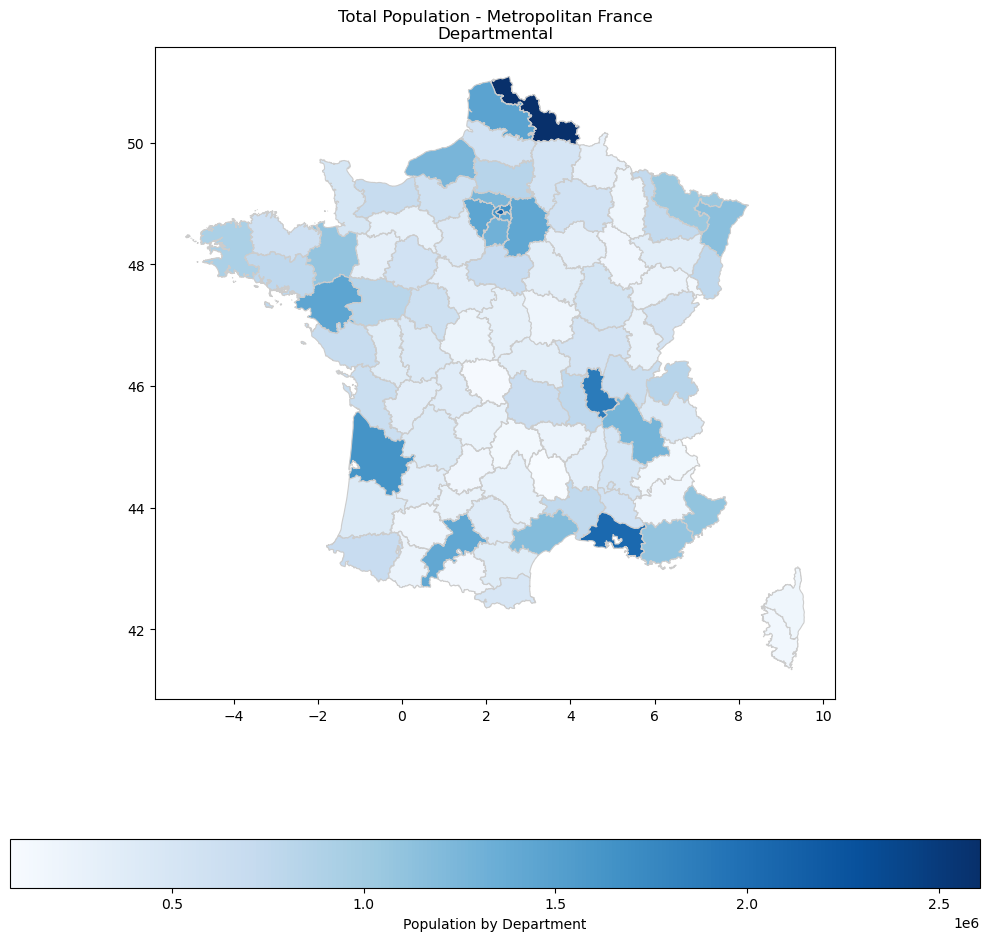

In [39]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create map
merged.plot(column='municipal_population',
            cmap='Blues',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True,
            legend_kwds={'label': "Population by Department",
                         'orientation': "horizontal"})
plt.title("Total Population - Metropolitan France\nDepartmental")
plt.tight_layout()
plt.show()

#### There's a huge range of values in `population_density`

We apply a log transformation and bin by 'natural breaks' in the data

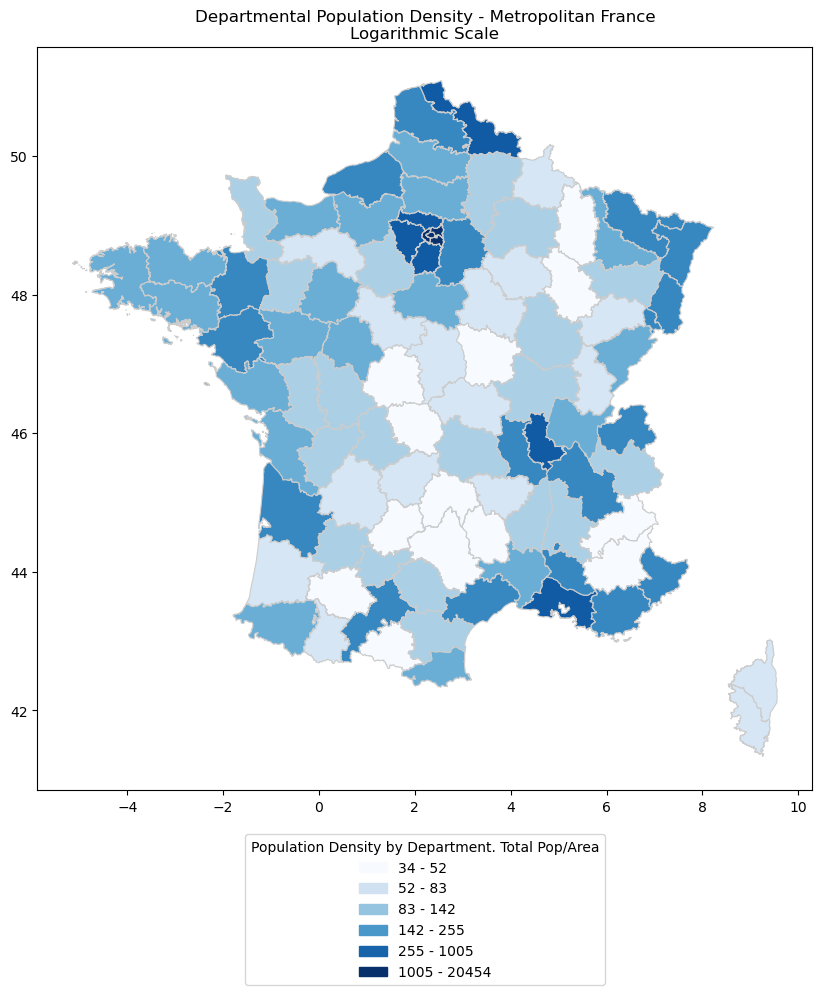

In [40]:
# Apply log transformation to the density column
merged['log_population_density'] = np.log(merged['population_density(inhabitants/sq_km)'] + 1)  # Add 1 or a small constant to avoid log(0)
# Define classification scheme
classifier = mapclassify.NaturalBreaks(merged['log_population_density'], k=7)  # Using NaturalBreaks
# Apply classification to dataframe
merged['classification'] = merged[['log_population_density']].apply(classifier)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create map
merged.plot(column='classification',
            cmap='Blues',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=False) # we will create a custom legend

# Create legend
labels = []
# Create a list of bin boundaries in original scale
bin_edges_exp = np.exp(classifier.bins) - 1
for i in range(len(bin_edges_exp) - 1):
    label = f"{bin_edges_exp[i]:.0f} - {bin_edges_exp[i+1]:.0f}"
    labels.append(mpatches.Patch(color=plt.cm.Blues(i / (len(bin_edges_exp) - 2)),
                                 label=label))
plt.legend(handles=labels,
           title='Population Density by Department. Total Pop/Area',
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center')
plt.title("Departmental Population Density - Metropolitan France\nLogarithmic Scale")
plt.show()

----
&nbsp;
## Grouping restaurants by `department` and `region` based on the number of Michelin stars.

In [41]:
# We create a copy
france_data_copy = france_data.copy()

# Create dummy variables for each category of 'star'
france_data_copy['bib_gourmand'] = france_data_copy['stars'].apply(lambda x: 1 if x == 0.5 else 0)
france_data_copy['1_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 1.0 else 0)
france_data_copy['2_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 2.0 else 0)
france_data_copy['3_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 3.0 else 0)

#### By `region`
We sort `france_data` by total number of awarded restaurants

In [42]:
# Group by 'region' and sum 'bib', '1_star', '2_star' and '3_star'
region_grouped = france_data_copy.groupby('region')[['bib_gourmand', '1_star', '2_star', '3_star']].sum()

# Create a copy for plotting
region_grouped_two = region_grouped.copy()

`region_grouped` is created to be merged with the demographics data

In [43]:
# Create a 'total_ star' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
region_grouped['total_stars'] = region_grouped['1_star']*1 + region_grouped['2_star']*2 + region_grouped['3_star']*3
# Create a 'total' column = sum of restaurants
region_grouped['starred_restaurants'] =  region_grouped['1_star'] + region_grouped['2_star'] + region_grouped['3_star']

# Sort the dataframe by the 'total_stars' column in descending order
region_grouped.sort_values('total_stars', ascending=True, inplace=True)

----
&nbsp;
### Plotting starred restaurants by `region`

We use `region_grouped_two` for plotting whilst excluding Île-de-France

In [44]:
# Create a 'total_starred' column - sum of starred restaurants
region_grouped_two['total_starred'] = region_grouped_two['1_star'] + region_grouped_two['2_star'] + region_grouped_two['3_star']

# Sort the dataframes by the 'total' and 'total_stars' columns in descending order
region_grouped_two.sort_values('total_starred', ascending=True, inplace=True)

In [45]:
# Exclude 'Île-de-France'
region_grouped_excl_paris = region_grouped_two[region_grouped_two.index.get_level_values('region') != 'Île-de-France']

In [46]:
# Drop the 'bib_gourmand' and 'total_starred' columns
region_grouped_excl_paris = region_grouped_excl_paris.copy()
region_grouped_excl_paris.drop(['bib_gourmand', 'total_starred'], axis=1, inplace=True)

Plot the data

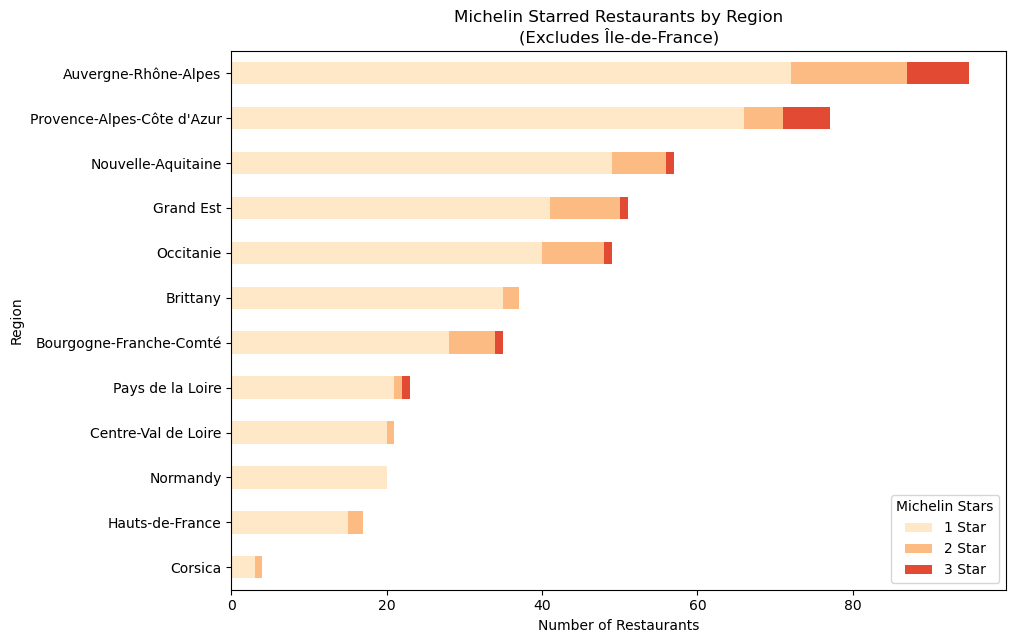

In [47]:
# Create a horizontal stacked bar plot
region_grouped_excl_paris.plot(kind='barh', stacked=True, figsize=(10, 7),
                    color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Michelin Starred Restaurants by Region\n(Excludes Île-de-France)')
plt.ylabel('Region')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
### By `department`

We sort `france_data` by total number of awarded restaurants

In [48]:
# Group by 'department' and sum 'bibs', '1_star', '2_star' and '3_star'
dept_grouped = france_data_copy.groupby(['department_num', 'department'])[['bib_gourmand', '1_star', '2_star', '3_star']].sum()

# Creating a copy for plotting
dept_grouped_two = dept_grouped.copy()

`dept_grouped` is created to be merged with the demographics data

In [49]:
# Create a 'total_ stars' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
dept_grouped['total_stars'] = dept_grouped['1_star']*1 + dept_grouped['2_star']*2 + dept_grouped['3_star']*3

# Create a 'starred_restaurants' column = sum of starred restaurants
dept_grouped['starred_restaurants'] =  dept_grouped['1_star'] + dept_grouped['2_star'] + dept_grouped['3_star']

# Sort the dataframe by the 'department_num' column in descending order
dept_grouped.sort_values('department_num', ascending=True, inplace=True)

Two new statistics have been created;
- `total_stars`: sum of **individual** stars
- `total_restaurants`

In [50]:
dept_grouped.tail()

,,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
department_num,department,,,,,,
91,Essonne,1,0,0,0,0,0
92,Hauts-de-Seine,3,3,0,0,3,3
93,Seine-Saint-Denis,0,1,0,0,1,1
94,Val-de-Marne,1,1,0,0,1,1
95,Val-d'Oise,0,2,0,0,2,2


----
&nbsp;
### Plotting starred restaurants by `department`
Using `dept_grouped_two`, we group and plot the top 10 departments by total stars. A subtly different statistic is created;
- `total_starred`: sum of restaurants with stars as opposed to sum of stars

In [51]:
# Create a 'total_starred' column
dept_grouped_two['total_starred'] = dept_grouped_two['1_star'] + dept_grouped['2_star'] + dept_grouped['3_star']

# Sort the dataframe by the 'department_num' column in descending order
dept_grouped_two.sort_values('department_num', ascending=True, inplace=True)

In [52]:
# Exclude 'Paris'
dept_grouped_no_paris = dept_grouped_two[dept_grouped_two.index.get_level_values('department').str.strip() != 'Paris']

In [53]:
# Sort by 'total_starred' in descending order and keep the top 10
dept_grouped_top10 = dept_grouped_no_paris.sort_values('total_starred', ascending=False).head(10)

# Drop the 'bib_gourmand' & 'total' columns
dept_grouped_top10 = dept_grouped_top10.drop(columns=['bib_gourmand', 'total_starred'])

# Reverse the order of the DataFrame
dept_grouped_top10 = dept_grouped_top10.iloc[::-1]

Plot the data

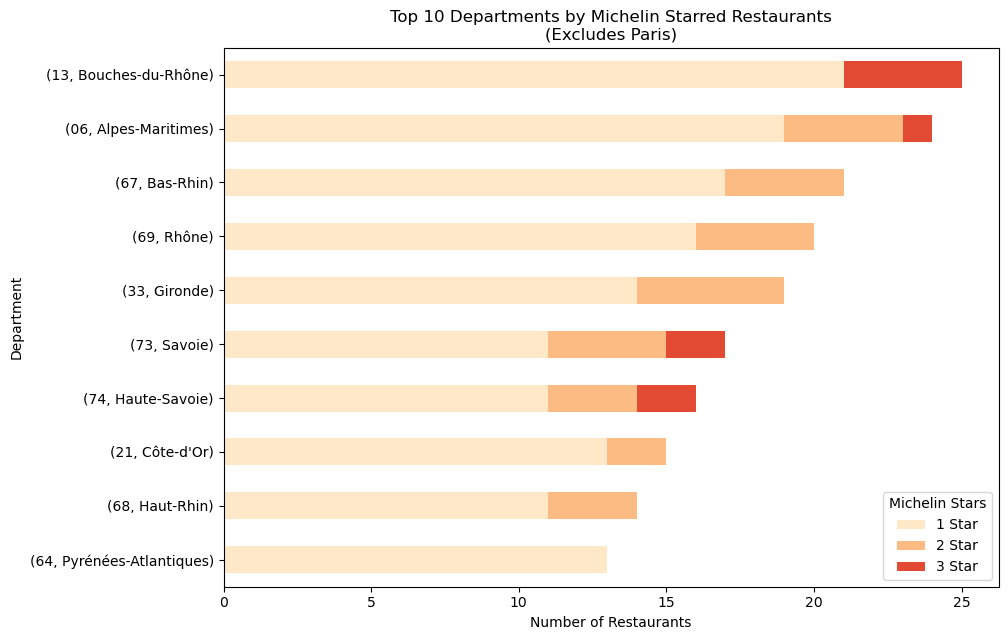

In [54]:
# Plot the data
dept_grouped_top10.plot(kind='barh', stacked=True, figsize=(10, 7),
                        color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Top 10 Departments by Michelin Starred Restaurants\n(Excludes Paris)')
plt.ylabel('Department')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
## Merging Michelin stars by `department` & `region` with the population demographics data

### Merging `dept_grouped` with `demographics`

In [55]:
print(f"Rows in `demographics`: {len(demographics)}")

# We index the multi-indexed df
dept_grouped.reset_index(inplace=True)
print(f"Rows in `dept_grouped`: {len(dept_grouped)}")

Rows in `demographics`: 96
Rows in `dept_grouped`: 92


There are some discrepancies. We create sets of unique `departments` for both DataFrames

In [56]:
set1 = set(dept_grouped['department'].unique())
set2 = set(demographics['department'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? False


In [57]:
print("In dept_grouped but not in demographics: ", set1 - set2)
print("In demographics but not in dept_grouped: ", set2 - set1)

In dept_grouped but not in demographics:  set()
In demographics but not in dept_grouped:  {'Deux-Sèvres', 'Tarn-et-Garonne', 'Aisne', 'Nièvre'}


Departments; 'Tarn-et-Garonne', 'Deux-Sèvres', 'Nièvre', & 'Aisne' contained zero Michelin rated restaurants (including bibs)

We will write them to `dept_grouped` with zero values

In [58]:
# Missing departments in `dept_grouped`
missing_dept_dict = {'Deux-Sèvres': '79', 'Nièvre': '58', 'Aisne': '02', 'Tarn-et-Garonne': '82'}

for dept in missing_dept_dict:
    dept_data = pd.Series({'department_num': missing_dept_dict[dept],
                           'department': dept,'bib_gourmand': 0, '1_star': 0, '2_star': 0, '3_star': 0,
                           'total_stars': 0, 'starred_restaurants': 0})

    dept_grouped = pd.concat([dept_grouped, pd.DataFrame([dept_data])], ignore_index=True)

In [59]:
set1 = set(dept_grouped['department'].unique())
set2 = set(demographics['department'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? True


We merge the dataframes

In [60]:
# Create a copy of demographics as we will also use 'demographics' for the regional dataframe
demographics_copy = demographics.copy()

In [61]:
# Sort dataframes on 'department_num'
dept_grouped = dept_grouped.sort_values('department_num')
demographics = demographics.sort_values('department_num')

In [62]:
# Merge demographics data with department data
departmental_data = dept_grouped.merge(demographics, how='inner', on='department_num')

In [63]:
print(departmental_data.columns.tolist())

['department_num', 'department_x', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'department_y', 'capital', 'region', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)']


In [64]:
# Drop 'department_y' column
departmental_data = departmental_data.drop('department_y', axis=1)

# Rename 'department_x' to 'department'
departmental_data = departmental_data.rename(columns={'department_x': 'department'})

# Order columns
departmental_data = departmental_data[['department_num', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star',
                                       'total_stars', 'starred_restaurants', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)',
                                       'area(sq_km)']]

In [65]:
departmental_data.head(3)

,department_num,department,capital,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,6,4,0,1,7,5,16726.40,25425.63,10.5,5.5,15.34,657856.0,114.2,5760.56
1,02,Aisne,Laon,Hauts-de-France,0,0,0,0,0,0,12016.40,22699.26,18.0,10.5,13.92,529374.0,71.9,7362.64
2,03,Allier,Moulins,Auvergne-Rhône-Alpes,4,2,0,0,2,2,8278.98,24667.13,15.3,7.7,13.63,335628.0,45.7,7344.16


In [66]:
departmental_data.shape

(96, 18)

----
&nbsp;
### Merging `region_grouped` with `demographics`

Summation of the numerical statistics by region in `demographics`

In [67]:
# Group the demographics data by 'region' and sum 'municipal_population' and 'area(sq_km)'
# First, we'll sum up the straightforward columns:
grouped_demographics = demographics_copy.groupby('region')[['municipal_population', 'area(sq_km)']].sum()

# Summing up the GDP for each region:
grouped_demographics['GDP_millions(€)'] = demographics_copy.groupby('region')['GDP_millions(€)'].sum().values

# Calculating GDP per capita for each region:
grouped_demographics['GDP_per_capita(€)'] = grouped_demographics['GDP_millions(€)'] * 1e6 / grouped_demographics['municipal_population']

# Calculate population density:
grouped_demographics['population_density(inhabitants/sq_km)'] = round(grouped_demographics['municipal_population'] /
                                                                      grouped_demographics['area(sq_km)'], 2)
# Computing weighted averages:
for col in ['poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)']:
    # Multiply the column by population to weight it
    demographics_copy[col + '_weighted'] = demographics_copy[col] * demographics_copy['municipal_population']
    # Group by region and sum the weighted values
    sum_weighted = demographics_copy.groupby('region')[col + '_weighted'].sum()
    # Divide by summed population to get the average for the region
    grouped_demographics[col] = sum_weighted / grouped_demographics['municipal_population']

grouped_demographics.reset_index(inplace=True)

In [68]:
# Merge demographics data with department data
regional_data = region_grouped.merge(grouped_demographics, how='inner', on='region')

# Change order to match departmental data
new_order = ['region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)']
regional_data = regional_data[new_order]

In [69]:
regional_data.head(3)

,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
0,Corsica,2,3,1,0,5,4,9083.98,26429.891097,18.322021,6.119266,14.021192,343701.0,39.62,8675.80
1,Hauts-de-France,9,15,2,0,19,17,163006.00,27177.930865,17.187712,8.842395,14.862533,5997734.0,188.59,31803.87
2,Normandy,26,20,0,0,20,20,92016.51,27669.794396,13.176007,6.915393,14.790087,3325522.0,111.30,29879.17


There's a slight discrepancy in the calculated GDP data for 2021 on [INSEE](https://statistiques-locales.insee.fr/#view=map1&c=indicator)

----
&nbsp;
## Adding the coordinates of individual restaurants.

In [70]:
print(france_data.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']


To enrich the dataset, we attach the precise (latitude, longitude) coordinates of specific starred restaurants ( We do not include bib gourmand awards) to both `regional_data` and `departmental_data`.

This will be in the form  of a dictionary:
```python
{
  '1_star': [(lat1, long1), (lat2, long2), ..., (latN, longN)],
  '2_star': [(lat1, long1), (lat2, long2), ..., (latN, longN)],
  '3_star': [(lat1, long1), (lat2, long2), ..., (latN, longN)],
}
```

This structure will enable us to record specific locations of Michelin-starred restaurants while maintaining a compact representation of the data.

### Regional

In [71]:
# Create a separate DataFrame with star ratings, regions, and coordinates
location_data_region = france_data[['stars', 'region', 'latitude', 'longitude']]

# Convert to a dictionary where keys are tuples of star rating and region
location_dict_region = location_data_region.groupby(['stars', 'region']).apply(lambda df: list(zip(df.latitude, df.longitude))).to_dict()

In [72]:
# Create a mapping from star values to string labels
star_label_mapping = {
    0.5: 'Bib',
    1: '1',
    2: '2',
    3: '3'
}

In [73]:
# Create a function to map these dictionaries to original DataFrame
def map_locations_region(row):
    return {star_label_mapping[stars]: location_dict_region.get((stars, row['region'])) for stars in [0.5, 1, 2, 3]}

In [74]:
# Apply this function to create a new 'locations' column
regional_data['locations'] = regional_data.apply(map_locations_region, axis=1)

### Departmental

In [75]:
# Create a separate DataFrame with star ratings, department, and coordinates
location_data_department = france_data[['stars', 'department_num', 'latitude', 'longitude']]

# Convert to a dictionary where keys are tuples of star rating and department
location_dict_department = location_data_department.groupby(['stars', 'department_num']).apply(lambda df: list(zip(df.latitude, df.longitude))).to_dict()

In [76]:
# Create a function to map these dictionaries to original DataFrame for departments
def map_locations_department(row):
    return {star_label_mapping[stars]: location_dict_department.get((stars, row['department_num'])) for stars in [0.5, 1, 2, 3]}

In [77]:
# Apply this function to create a new 'locations' column
departmental_data['locations'] = departmental_data.apply(map_locations_department, axis=1)

----
&nbsp;
## Merging with the GeoJSON data

We merge `departmental_data` with `departements.geojson`

In [78]:
gdf_dept = gpd.read_file('../../data/France/Geodata/departements.geojson')
gdf_dept.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


We will merge on `code` and check the two sets of departmental codes are equal

In [79]:
set1 = set(departmental_data['department_num'].unique())
set2 = set(gdf_dept['code'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? True


In [80]:
# Merge dataframes
dept_rest_demo = gdf.set_index('code').join(departmental_data.set_index('department_num'))

# Reset index to keep 'department_num' as a column
dept_rest_demo.reset_index(inplace=True)

# Delete 'nom' column in place
dept_rest_demo.drop(columns='nom', inplace=True)

print(len(dept_rest_demo))
dept_rest_demo.head()

96


,code,geometry,department,capital,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km),locations
0,01,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,6,4,0,1,7,5,16726.40,25425.63,10.5,5.5,15.34,657856.0,114.2,5760.56,"{'Bib': [(46.30794, 4.92875), (46.3846303, 5.3..."
1,02,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",Aisne,Laon,Hauts-de-France,0,0,0,0,0,0,12016.40,22699.26,18.0,10.5,13.92,529374.0,71.9,7362.64,"{'Bib': None, '1': None, '2': None, '3': None}"
2,03,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...",Allier,Moulins,Auvergne-Rhône-Alpes,4,2,0,0,2,2,8278.98,24667.13,15.3,7.7,13.63,335628.0,45.7,7344.16,"{'Bib': [(46.2356555, 3.4258809), (46.1248938,..."
3,04,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur,1,3,0,0,3,3,4154.79,25111.91,16.6,8.2,14.15,165451.0,23.9,6922.64,"{'Bib': [(43.8277724, 5.7863878)], '1': [(43.8..."
4,05,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur,2,1,0,0,1,1,3756.22,26714.70,13.9,6.9,13.54,140605.0,25.3,5557.51,"{'Bib': [(44.8999664, 6.6435838), (44.3149388,..."


----
&nbsp;
We merge `regional_data` with the GeoJSON data; `regions.geojson`

In [81]:
gdf_region = gpd.read_file('../../data/France/Geodata/regions.geojson')
gdf_region.head()

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ..."
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.88845 47.50943, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.07822 49.38849..."
4,32,Hauts-de-France,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."


In [82]:
set1 = set(regional_data['region'].unique())
set2 = set(gdf_region['nom'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? False


In [83]:
print("In set1 but not in set2: ", set1 - set2)
print("In set2 but not in set1: ", set2 - set1)

In set1 but not in set2:  {'Normandy', 'Brittany', 'Corsica'}
In set2 but not in set1:  {'Bretagne', 'Corse', 'Normandie'}


I will change `regional_data` to the French spelling

In [84]:
# Define a dictionary to map English region names to French
region_translation = {'Brittany': 'Bretagne', 'Corsica': 'Corse', 'Normandy': 'Normandie'}

# Use replace to update the 'region' column
regional_data['region'] = regional_data['region'].replace(region_translation)

We also update `region` in `dept_rest_demo`

In [85]:
dept_rest_demo['region'] = dept_rest_demo['region'].replace(region_translation)

In [86]:
set1 = set(regional_data['region'].unique())
set2 = set(dept_rest_demo['region'].unique())
set3 = set(gdf_region['nom'].unique())
print(f"Sets equal? {set1 == set2 == set3}")

Sets equal? True


In [87]:
# Merge the dataframes on 'nom' and 'region'
region_rest_demo = gdf_region.merge(regional_data, left_on='nom', right_on='region')

In [88]:
# Delete 'nom' column in place
region_rest_demo.drop(columns=['code', 'nom'], inplace=True)

In [89]:
region_rest_demo.head()

,geometry,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km),locations
0,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ...",Île-de-France,46,110,15,9,167,134,700754.40,57102.849021,15.544561,7.002391,20.681268,12271794.0,1021.62,12012.13,"{'Bib': [(48.8852338, 2.3373871), (48.83249, 2..."
1,"POLYGON ((2.87463 47.52042, 2.88845 47.50943, ...",Centre-Val de Loire,23,20,1,0,22,21,72707.28,28237.339229,12.898109,6.796385,14.801967,2574863.0,65.76,39153.00,"{'Bib': [(47.9240493, 0.8506476), (47.261303, ..."
2,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ...",Bourgogne-Franche-Comté,20,28,6,1,43,35,76921.54,27455.358274,12.778156,6.318556,14.355314,2801695.0,58.65,47771.30,"{'Bib': [(46.565698, 4.908016), (47.1239245, 6..."
3,"POLYGON ((-1.11962 49.35557, -1.07822 49.38849...",Normandie,26,20,0,0,20,20,92016.51,27669.794396,13.176007,6.915393,14.790087,3325522.0,111.30,29879.17,"{'Bib': [(49.0345872, -1.5249411), (49.2406241..."
4,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ...",Hauts-de-France,9,15,2,0,19,17,163006.00,27177.930865,17.187712,8.842395,14.862533,5997734.0,188.59,31803.87,"{'Bib': [(50.2377902, 1.6621716), (50.9569152,..."


Both datasets will be exported for further analysis

In [90]:
# Export the GeoDataFrame to a .geojson file
region_rest_demo.to_file('../../data/France/region_restaurants.geojson', driver='GeoJSON')

In [91]:
# Export the GeoDataFrame to a .geojson file
dept_rest_demo.to_file('../../data/France/department_restaurants.geojson', driver='GeoJSON')